7500000000.0


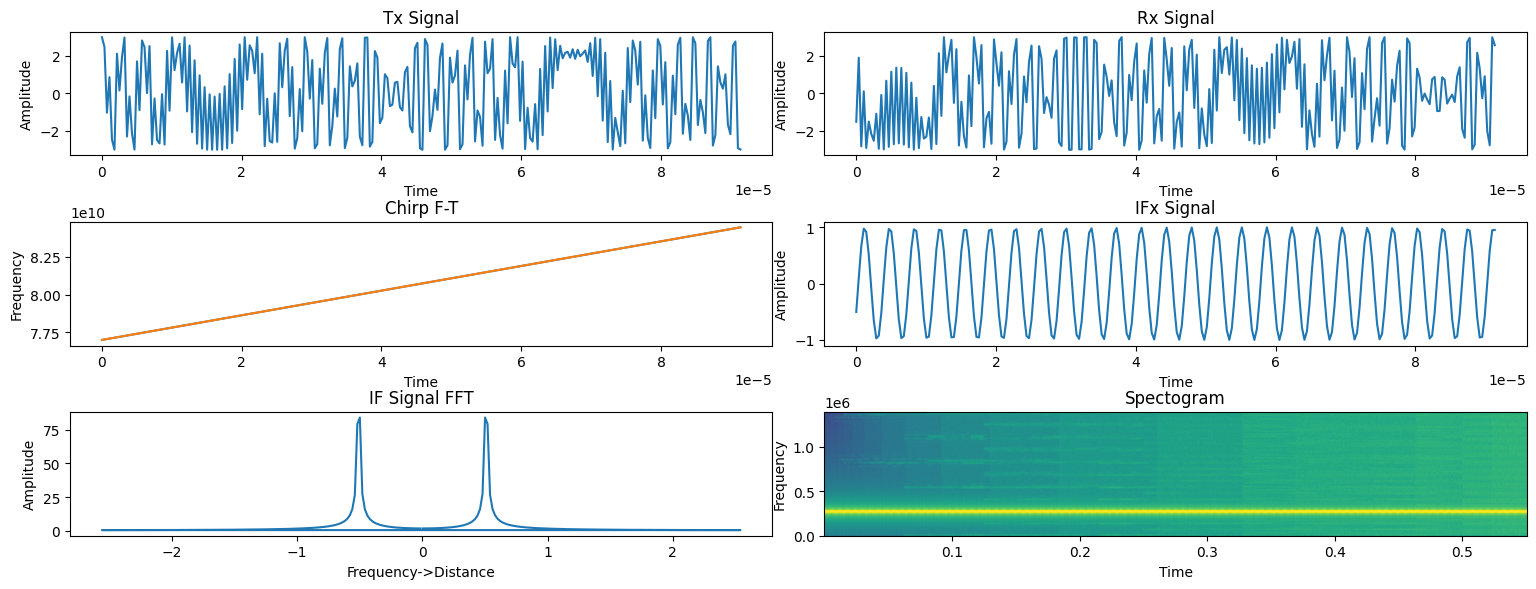

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
#Radar parameters setting

maxR = 11

maxV = 70 
fc = 77e9 #Carrier frequency
c = 3e8 

r0 = 0.5 #target distance
v0 = 0 #target velocity


# rangeRes = c/(2*B)

rangeRes = 0.02
B = c/(2*rangeRes)
print(B)

Tchirp = 91.72 * (1e-6)
endle_time = 6.3e-6
slope = B/Tchirp 
f_IFmax = (slope*2*maxR)/c
f_IF = (slope*2*r0)/c 

Nd =  6000 # number of chirp
Nr = 256 #number of sample per chirp

SAMPLE_COUNT_CHIRP =256

vres = (c/fc)/(2*Nd*(Tchirp+endle_time)) 

Fs = Nr/Tchirp  #Sampling rate

amplitude_TX=3
amplitude_RX=3

t = np.linspace(0,Nd*Tchirp,Nr*Nd,endpoint=False) 

angle_freq = fc*t+(slope*t*t)/2 
freq = fc + slope*t 
Tx = amplitude_TX *np.cos(2*np.pi*angle_freq)

plt.figure(figsize=(16,8))

plt.subplot(4,2,1)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],Tx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],freq[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Tx F-T')

r0 = r0+v0*t


td = 2*r0/c
tx = t
freqRx = fc + slope*(t)


breathing_freq = 0.3  # Frequency in Hz
heart_freq = 2  # Frequency in Hz
vibration_amplitude_mm = 0.04  # Amplitude of the signal
vibration_amplitude_mm_heart = 0.01  # Amplitude of the signal
duration = 300  # Duration in seconds
sampling_rate = 20*256  # Sampling rate in Hz

# Time array
breath_time = np.arange(0, duration, 1 / sampling_rate)
heart_time = np.arange(0, duration, 1 / sampling_rate)

# Calculate target vibration displacement profile (using a sinusoidal function for breathing-like motion)
vibration_displacement = vibration_amplitude_mm * np.sin(2 * np.pi * breathing_freq * breath_time)
vibration_displacement_heart = vibration_amplitude_mm_heart * np.sin(2 * np.pi * heart_freq * heart_time)



# Calculate the phase shift for the vibration effect in received signal
#phase_shift = -2 * np.pi * fc * (vibration_displacement / c)
Rx = amplitude_RX *np.cos(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2)) #接受波形函数


plt.subplot(4,2,2)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],Rx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:SAMPLE_COUNT_CHIRP]+td[0:SAMPLE_COUNT_CHIRP],freqRx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Chirp F-T')

phase_shift=0
phase_shift+=(4 * np.pi * (r0+vibration_displacement))/0.04 
phase_shift +=(4 * np.pi * (r0+vibration_displacement_heart))/0.04
IF_angle_freq = fc*t+(slope*t*t)/2 - ((fc*(t-td) + (slope*(t-td)*(t-td))/2))
freqIF = slope*td
IFx = np.cos(-(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2))+(2*np.pi*angle_freq)+phase_shift)


# IFx = Rx * np.conj(Tx)
plt.subplot(4,2,4)
plt.plot(t[0:SAMPLE_COUNT_CHIRP],IFx[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('IFx Signal')

#Range FFT
# doppler = 10*np.log10(np.abs(np.fft.fft(IFx[0:1024])))
doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_freq = frequency*c/(2*slope)
plt.subplot(4,2,5)
plt.plot(range_freq[0:SAMPLE_COUNT_CHIRP],doppler[0:SAMPLE_COUNT_CHIRP])
plt.xlabel('Frequency->Distance')
plt.ylabel('Amplitude')
plt.title('IF Signal FFT')

#2D plot
plt.subplot(4,2,6)
plt.specgram(IFx,SAMPLE_COUNT_CHIRP,Fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectogram')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()



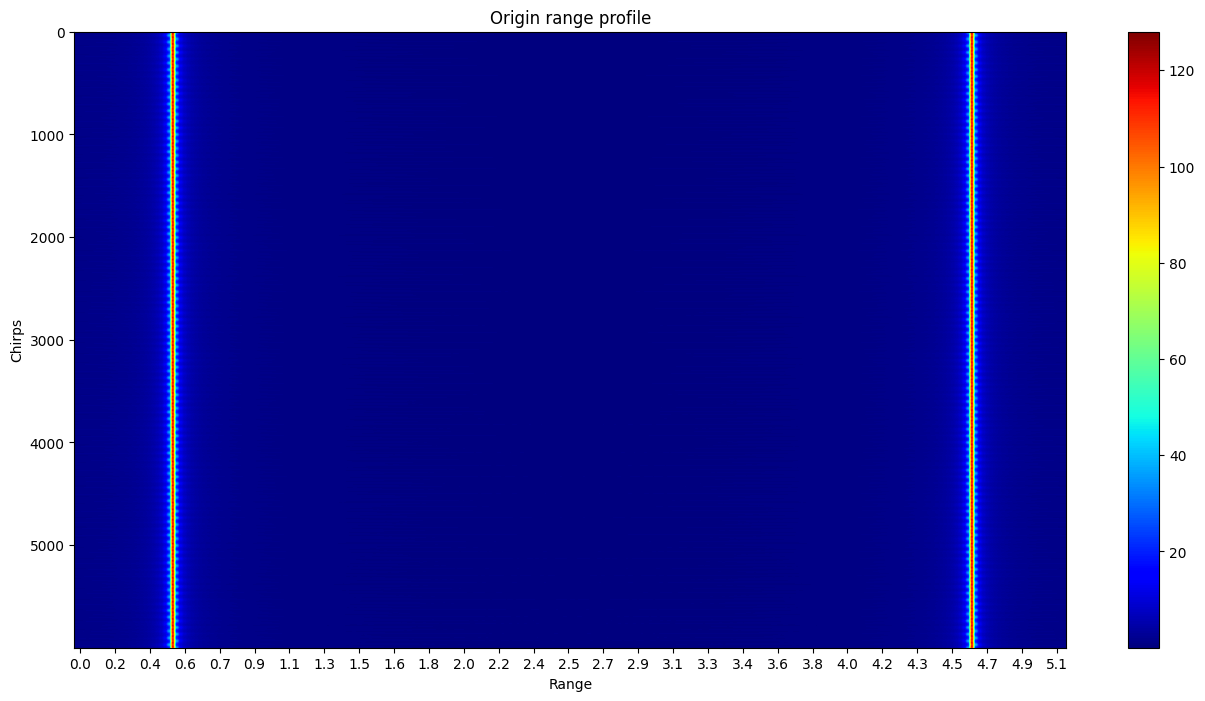

In [7]:
IFMatrix =IFx.reshape(Nd,Nr)
rangeProfiles =np.fft.fft (IFMatrix,axis=1)
magnitude_range_profile = [np.abs(profile) for profile in rangeProfiles]
# freqs = np.fft.fftfreq(len(rangeProfiles[0]), 1/Fs)
# doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
# frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_fre = frequency*c/(2*slope)
rangeBinDistance = [round(j*rangeRes,1) for j in range(1,Nr,9) ]

plt.figure(figsize=(16,8))
plt.xlabel('Range')
plt.ylabel('Chirps')
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
plt.colorbar()
# plt.xticks(rangeBinDistance)
plt.xticks(range(1,Nr,9), rangeBinDistance)
plt.title("Origin range profile")
plt.show()


In [9]:
range_profile_shape = np.array(rangeProfiles).shape
range_bin = range_profile_shape[1]
frame_number =range_profile_shape[0]

estimated_background_range_profile = np.zeros(range_bin,dtype=complex)
for bin_index in range (0,range_bin):
    estimated_background_range_profile[bin_index] = np.average(np.array(rangeProfiles)[:,bin_index])
print("background estimation: ",estimated_background_range_profile.shape)

removal_background_range_profile =np.zeros_like(rangeProfiles)
for  bin_index in range (0,range_bin):
    for frame_index in range(0,frame_number):
        removal_background_range_profile [frame_index][bin_index] = rangeProfiles[frame_index][bin_index] - estimated_background_range_profile[bin_index]
print("background removal range profile: ",removal_background_range_profile.shape)   

background estimation:  (256,)
background removal range profile:  (6000, 256)


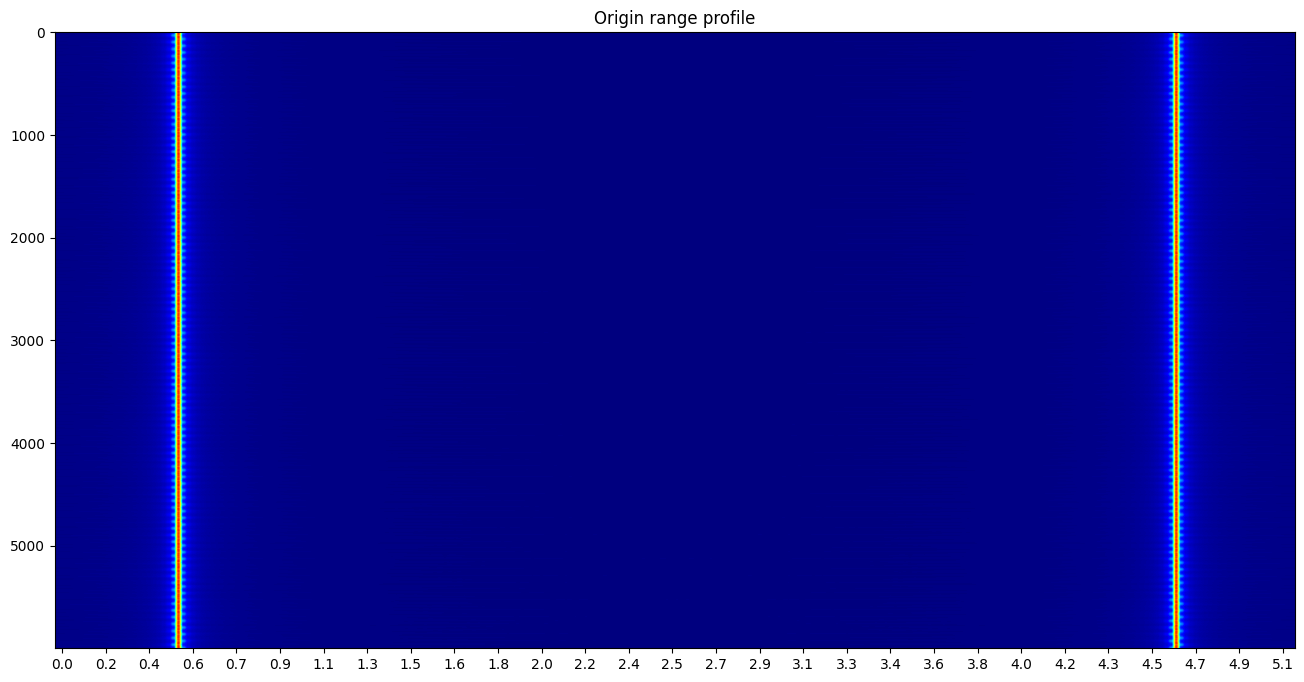

In [15]:
magnitude_range_profile = [np.abs(profile) for profile in removal_background_range_profile]
doppler = np.abs(np.fft.fft(IFx[0:SAMPLE_COUNT_CHIRP]))
frequency = np.fft.fftfreq(SAMPLE_COUNT_CHIRP, 1/Fs)
range_fre = frequency*c/(2*slope)
rangeBinDistance = [round(j*rangeRes,1) for j in range(1,Nr,9) ]

plt.figure(figsize=(16,8))
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
plt.xticks(range(1,Nr,9), rangeBinDistance)
plt.title("Origin range profile")
plt.show()


In [16]:
magnitude_range_profile_shape =np.array(magnitude_range_profile).shape
max_indices =[0]*magnitude_range_profile_shape[0]
for mag_profile in magnitude_range_profile:
    max_index = np.argmax(mag_profile)
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print(interesting_bin)

25


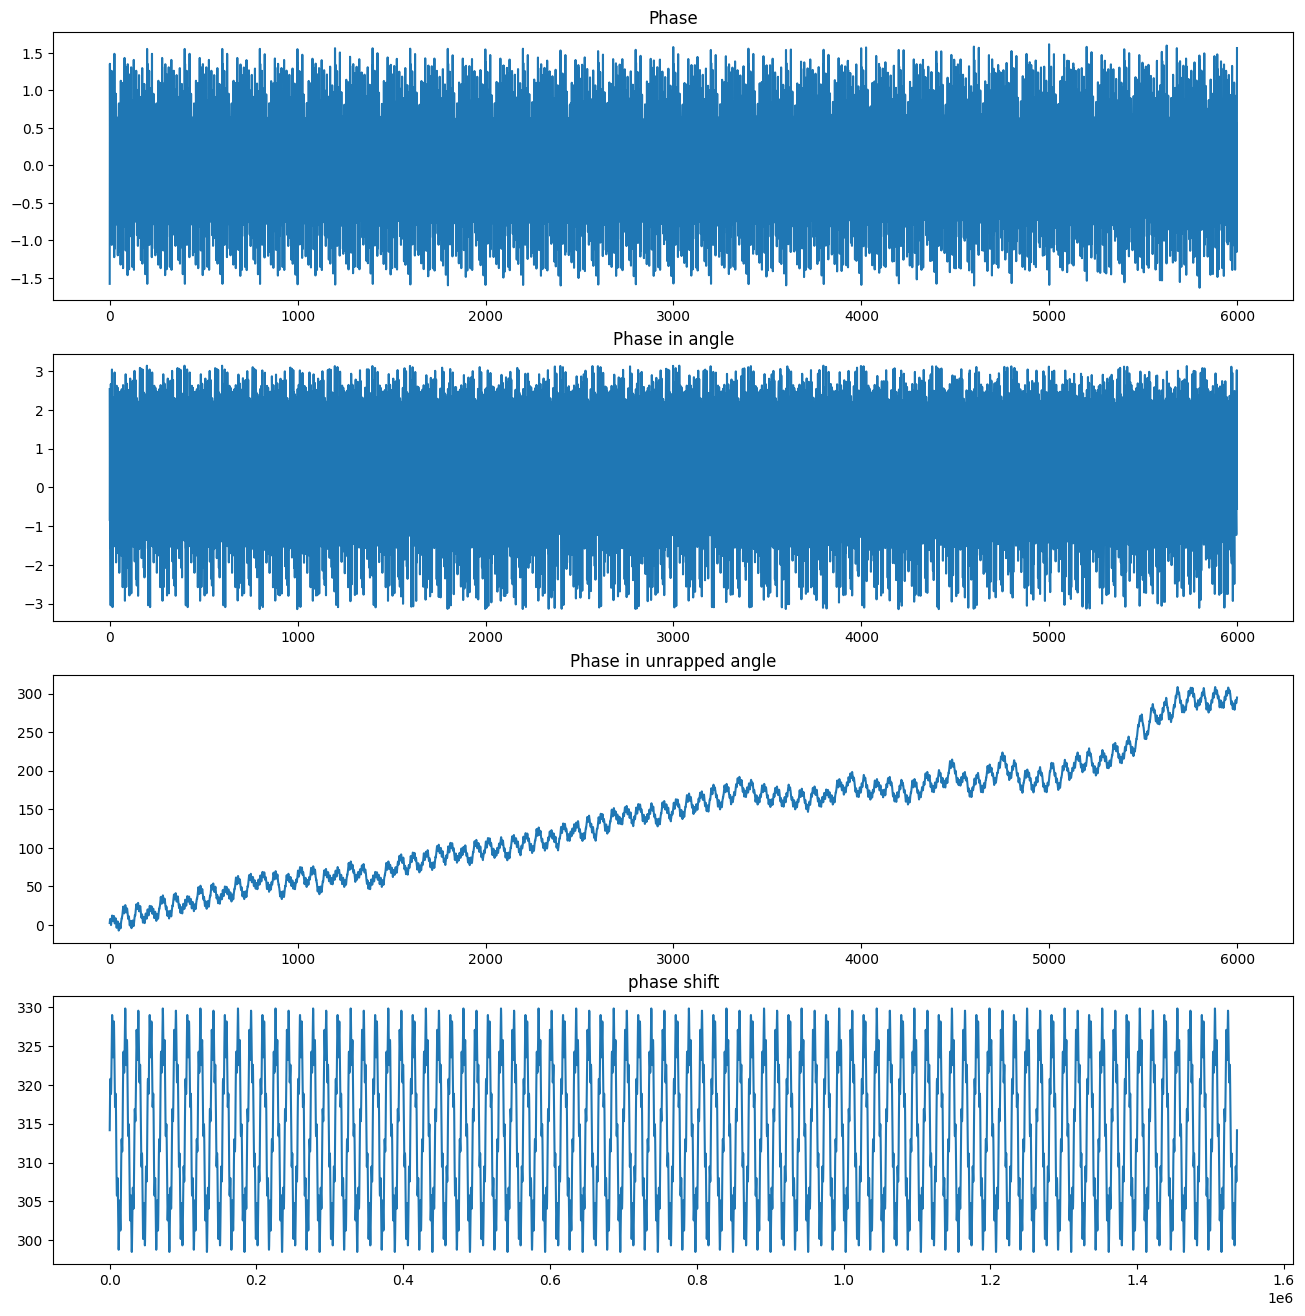

In [17]:
interest_bin_phase = np.array(rangeProfiles)[:,50]
interest_bin_angle = np.angle(interest_bin_phase)
interest_bin_angle_unwrapped= np.unwrap(interest_bin_angle)
plt.figure(figsize=(16,16))
plt.subplot(411)
plt.plot(interest_bin_phase)
plt.title("Phase")
plt.subplot(412)
plt.plot(interest_bin_angle)
plt.title("Phase in angle")
plt.subplot(413)
plt.plot(interest_bin_angle_unwrapped)
plt.title("Phase in unrapped angle")
plt.subplot(414)
plt.plot(phase_shift)
plt.title("phase shift")
plt.show()

# phase_shiftMatrix =phase_shift.reshape(Nd,Nr)
# fft_bin = np.fft.fft(interest_bin_phase[0:1200])
# plt.plot(fft_bin)
# plt.show()

In [18]:

complex_number_i = np.empty(len(phase_shift),dtype=complex)
for i_phase,phase in enumerate(phase_shift):
    real_component = vibration_amplitude_mm * np.cos(phase)
    imaginary_component = vibration_amplitude_mm * np.sin(phase)
    complex_number = complex(real_component, imaginary_component)
    complex_number_i[i_phase]=complex_number

<function matplotlib.pyplot.show(close=None, block=None)>

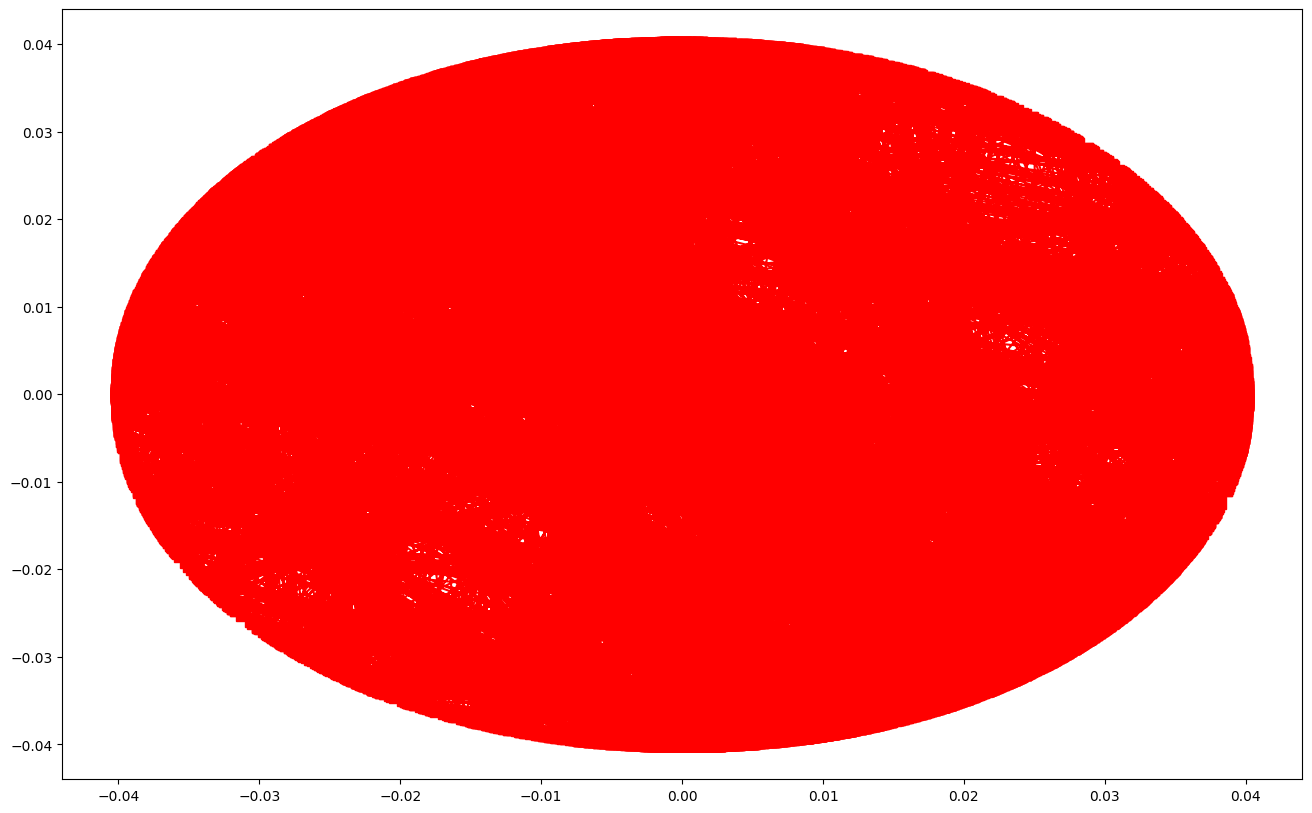

In [19]:
complex_interesting_bin = np.empty(len(interest_bin_angle_unwrapped),dtype=complex)
for i_phase,phase in enumerate(interest_bin_angle_unwrapped):
    real_component = vibration_amplitude_mm * np.cos(phase)
    imaginary_component = vibration_amplitude_mm * np.sin(phase)
    complex_phase = complex(real_component, imaginary_component)
    complex_interesting_bin[i_phase]=complex_phase
target_data_sample_real = [target_data_sample.real for target_data_sample in complex_interesting_bin]
target_data_sample_image =[target_data_sample.imag for target_data_sample in complex_interesting_bin]

plt.figure(figsize=(16, 10))
plt.plot(target_data_sample_real, target_data_sample_image, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(target_data_sample_real, target_data_sample_image, color='red')
plt.show

In [20]:
def extractPhase(interestingRangeBin):
    interestingRangeBinLen =len(interestingRangeBin)
    phaseExtracted = np.zeros(len(interestingRangeBin),dtype=float)
    phaseExtracted[0]=np.angle(interestingRangeBin[0])
    
    for i in range(1,interestingRangeBinLen):        
        tmpPhase =0
        for j in range(1,i):
            I_k=interestingRangeBin[j].real
            Q_k=interestingRangeBin[j].imag
            I_k_prev=interestingRangeBin[j-1].real
            Q_k_prev=interestingRangeBin[j-1].imag
            tmpPhase+= (I_k * (Q_k - Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k**2 + Q_k **2)

        phaseExtracted[i]= tmpPhase
    return phaseExtracted

In [21]:
# extracted= extractPhase(np.array(rangeProfiles)[:,50])
# plt.figure(figsize=(12,6))
# plt.plot(extracted)
# plt.show()

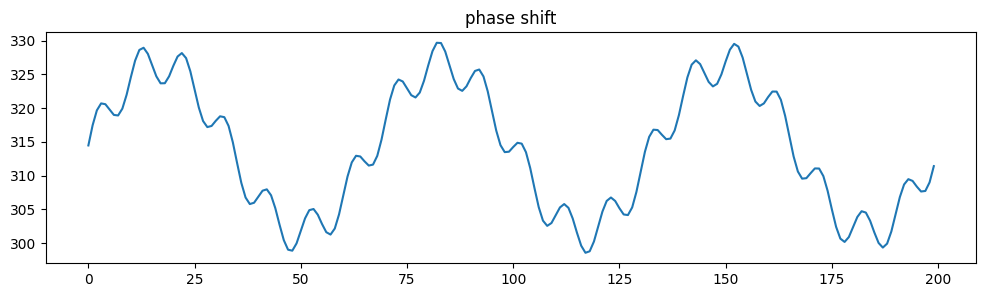

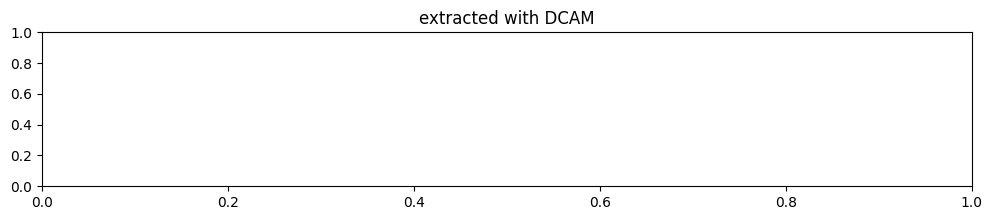

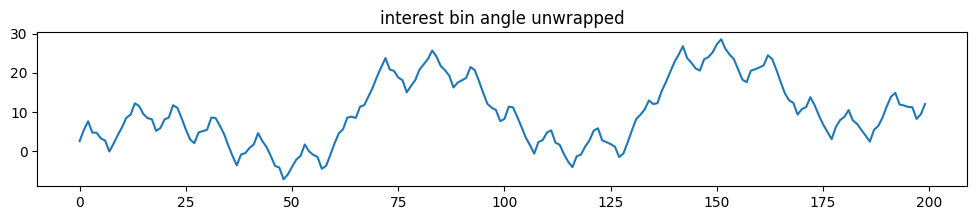

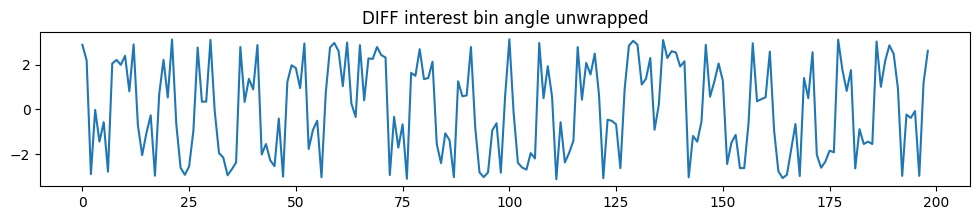

In [22]:
range_plot=20*10
tmp_phase_shift = phase_shift.reshape(Nd,Nr)
tmp_phase_shift_interesting =np.array(tmp_phase_shift)[:,interesting_bin]
plt.figure(figsize=(12,3))
plt.plot(tmp_phase_shift_interesting[:range_plot])
plt.title("phase shift")
plt.show()

plt.figure(figsize=(12,2))
# plt.plot(extracted[:range_plot])
plt.title("extracted with DCAM")
plt.show()

plt.figure(figsize=(12,2))
plt.plot(interest_bin_angle_unwrapped[:range_plot])
plt.title("interest bin angle unwrapped")
plt.show()


plt.figure(figsize=(12,2))
plt.plot(np.diff(interest_bin_angle_unwrapped[:range_plot]))
plt.title("DIFF interest bin angle unwrapped")
plt.show()



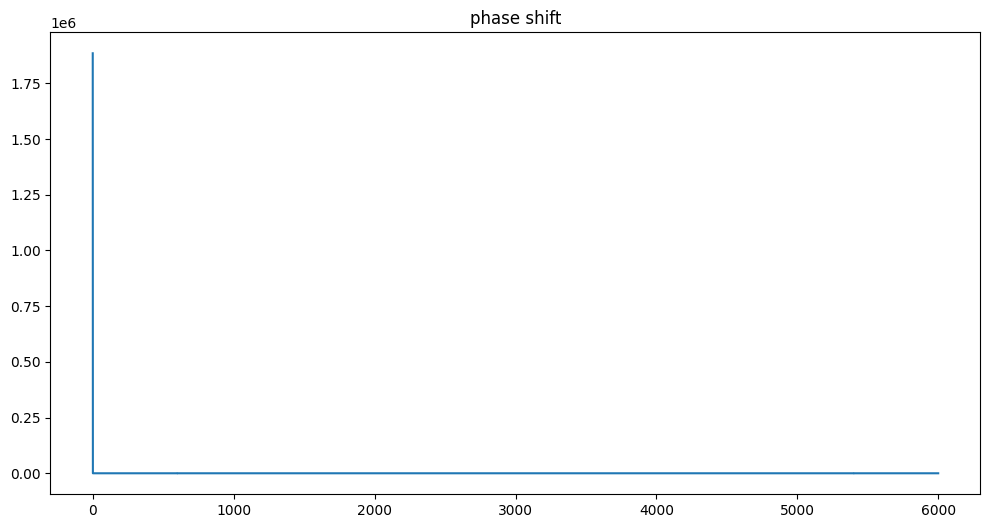

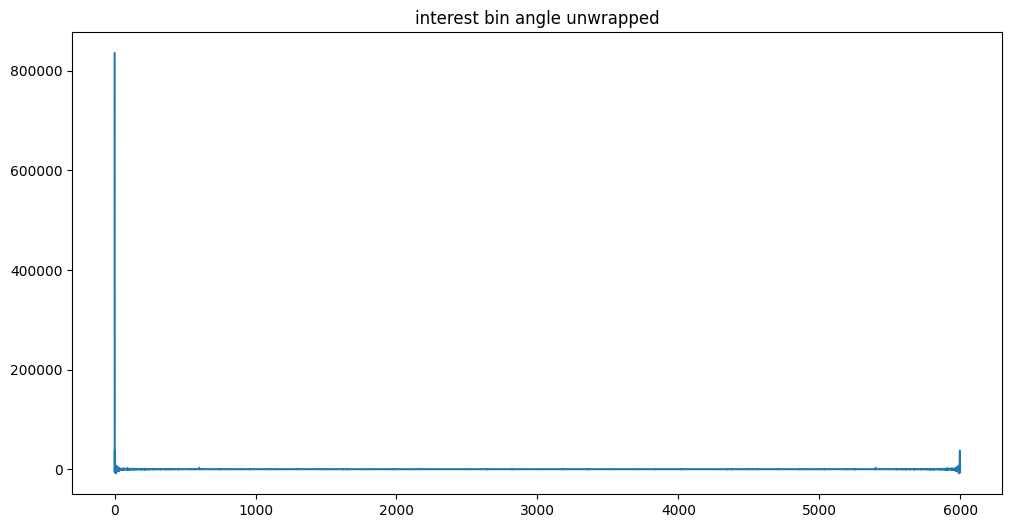

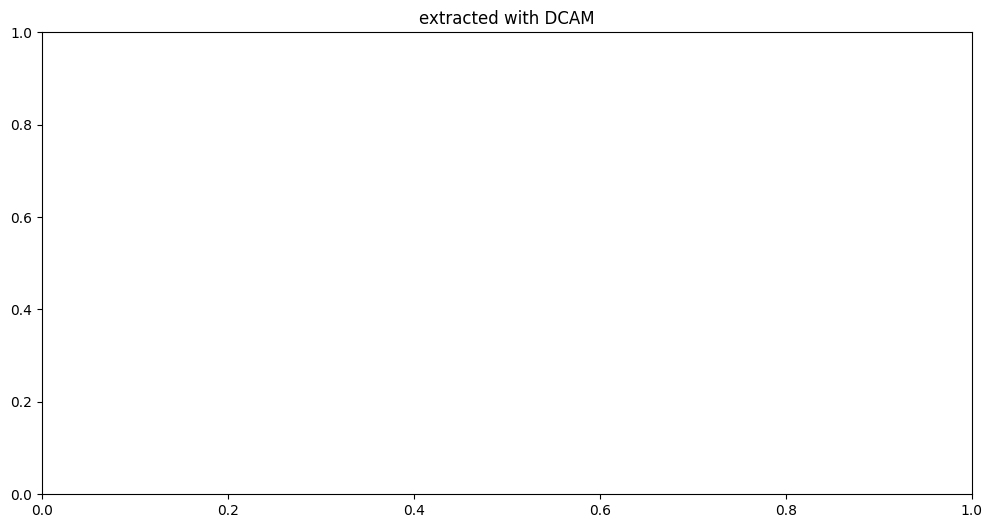

In [23]:
plt.figure(figsize=(12,6))

plt.plot(np.fft.fft(tmp_phase_shift_interesting))
plt.title("phase shift")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(np.fft.fft(interest_bin_angle_unwrapped))
plt.title("interest bin angle unwrapped")
plt.show()

plt.figure(figsize=(12,6))
# plt.plot(np.fft.fft(extracted))
plt.title("extracted with DCAM")
plt.show()

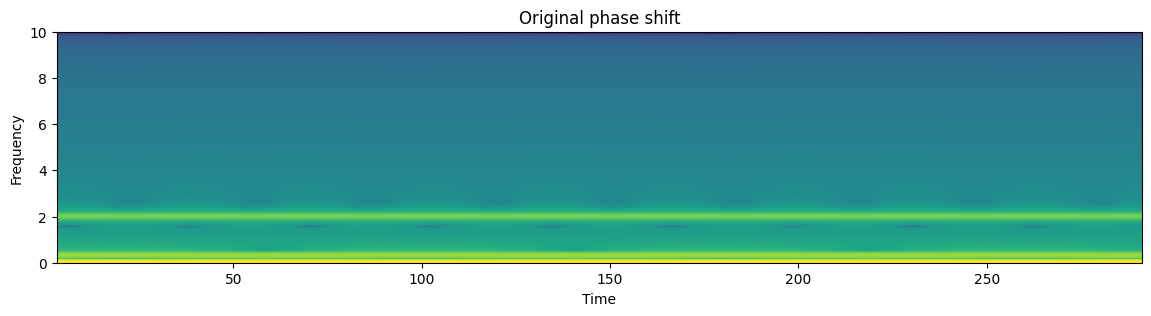

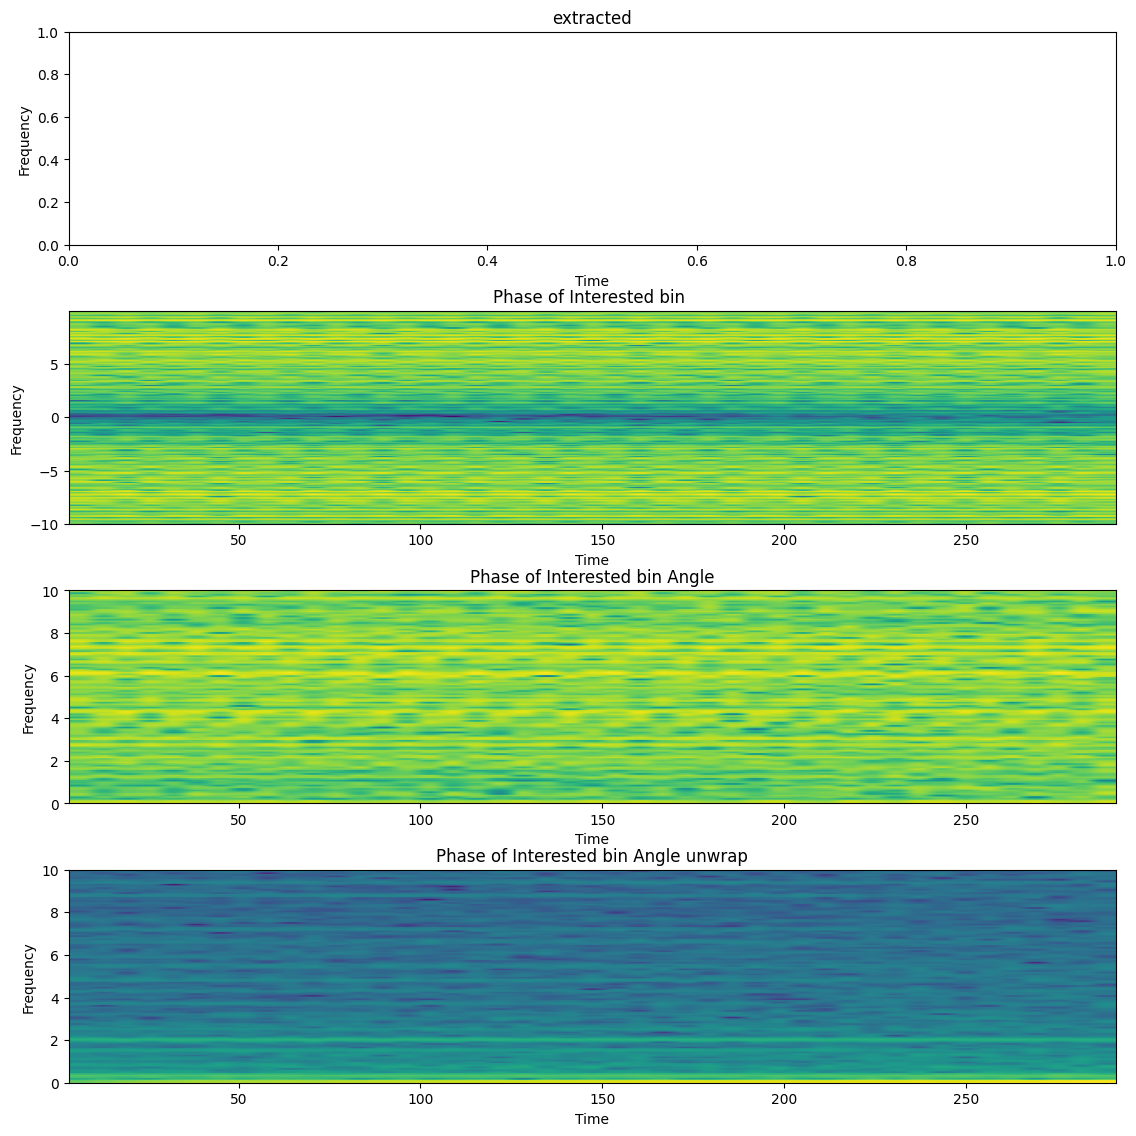

In [24]:
# interest_bin_angle = np.angle(interest_bin_phase)
# interest_bin_angle_unwrapped= np.unwrap(interest_bin_angle)


plt.figure(figsize=(14,3))

plt.specgram(tmp_phase_shift_interesting,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Original phase shift')
plt.show()

plt.figure(figsize=(12,12))
plt.subplot(411)
# plt.specgram(extracted,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('extracted')


plt.subplot(412)
plt.specgram(interest_bin_phase,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Phase of Interested bin ')


plt.subplot(413)
plt.specgram(interest_bin_angle,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Phase of Interested bin Angle')


plt.subplot(414)
plt.specgram(interest_bin_angle_unwrapped,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Phase of Interested bin Angle unwrap')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()


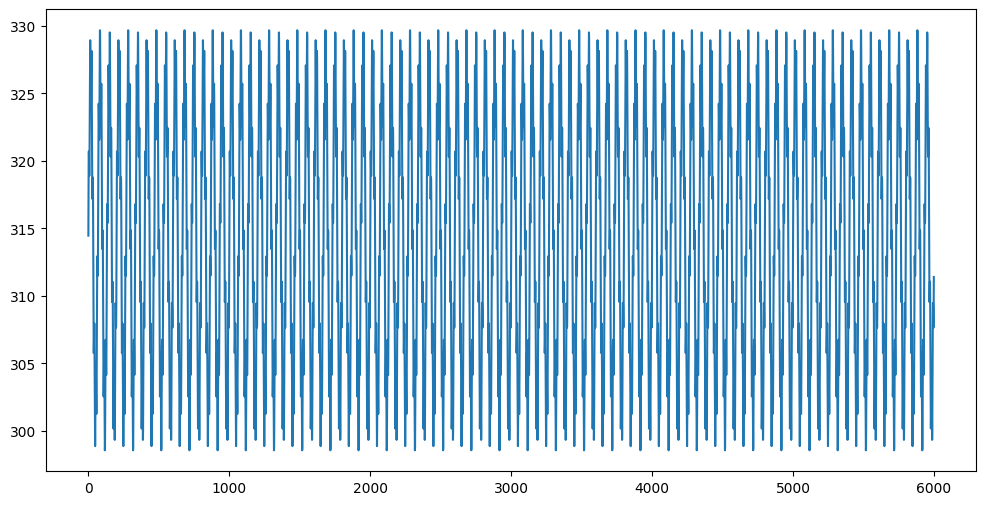

NameError: name 'extracted' is not defined

<Figure size 1200x600 with 0 Axes>

In [25]:
plt.figure(figsize=(12,6))
plt.plot(tmp_phase_shift_interesting)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(extracted)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(interest_bin_angle_unwrapped)
plt.show()


In [ ]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

Text(0.5, 1.0, 'interest_bin_angle_unwrapped')

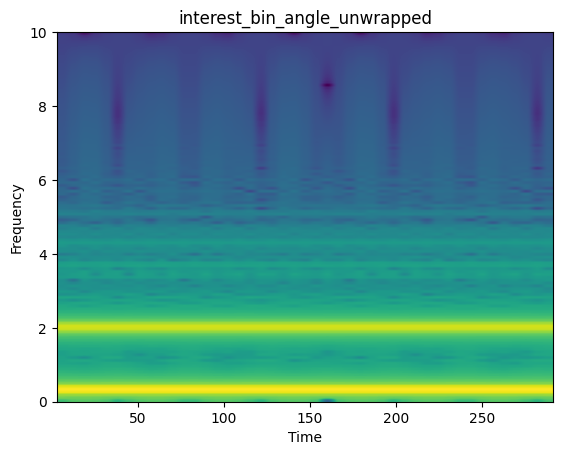

In [ ]:
SR=1200/60
breath_heart_band_filtering=[0.2,4]
filtered_signal =filter_signal(np.array(interest_bin_angle_unwrapped),breath_heart_band_filtering[0],breath_heart_band_filtering[1],SR,4)
plt.specgram(filtered_signal,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_angle_unwrapped')

Text(0.5, 1.0, 'interest_bin_angle_unwrapped')

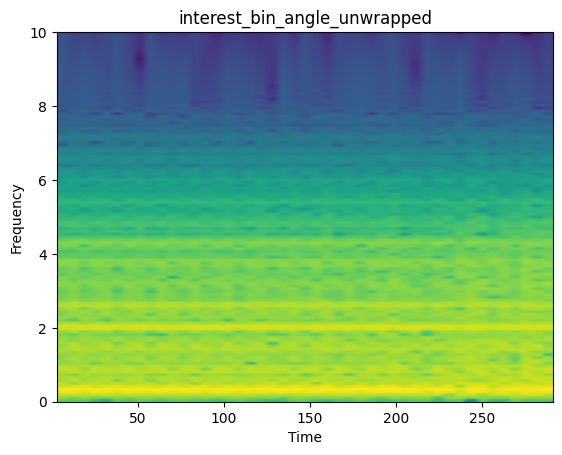

In [ ]:
SR=1200/60
breath_heart_band_filtering=[0.2,4]
filtered_signal =filter_signal(np.array(extracted),breath_heart_band_filtering[0],breath_heart_band_filtering[1],SR,4)
plt.specgram(filtered_signal,Fs=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_angle_unwrapped')